In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import metrics
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

%matplotlib inline

In [3]:
train_data_dir = r'C:\Users\johns\Desktop\TFG\NA\train'
validation_data_dir = r'C:\Users\johns\Desktop\TFG\NA\valid'

In [4]:
width_shape = 224
height_shape = 224
epochs = 100
num_classes = len(os.listdir(train_data_dir))
batch_size = 32
image_shape = (224,224,3)

Found 3860 images belonging to 24 classes.
Found 120 images belonging to 24 classes.


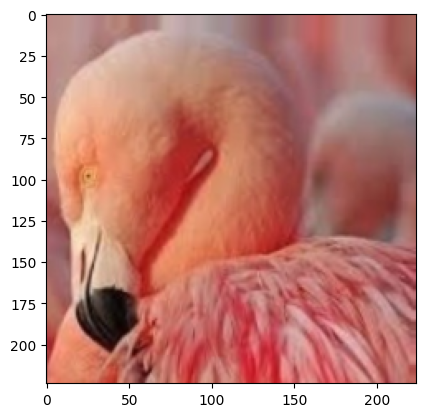

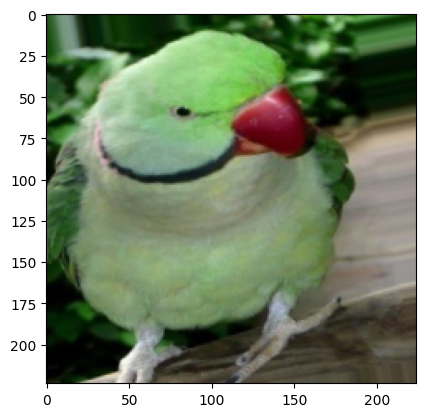

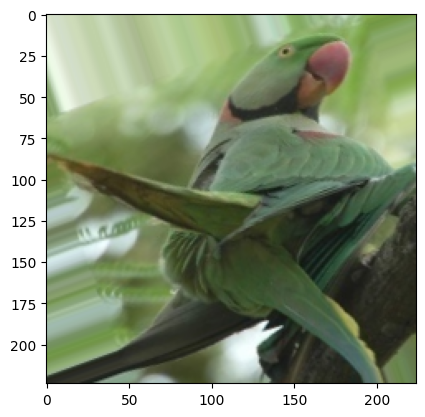

In [5]:
from keras.applications.resnet_v2 import preprocess_input

# Data generators with data augmentation
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(height_shape, width_shape),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = valid_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(height_shape, width_shape),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

for _ in range(3):
    img, label = next(train_generator)
    plt.imshow(img[0])
    plt.show()

In [6]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load InceptionV3 base model
base_model = InceptionV3(include_top=False, input_shape=(height_shape, width_shape, 3))

# # Freeze the layers in the base model
base_model.trainable = False

# Add your custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Create a dictionary mapping class indices to their respective class weights
class_weights_dict = dict(zip(np.unique(train_generator.classes), class_weights))

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # You can also monitor other metrics like 'val_accuracy'
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Create final model
custom_inceptionv3_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
custom_inceptionv3_model.compile(loss='categorical_crossentropy',
                                 optimizer=Adam(),
                                 metrics=['accuracy'])

# Train the model
custom_inceptionv3_model_history = custom_inceptionv3_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    class_weight=class_weights_dict,  # Pass class weights
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
120/120 [==============================] - 40s 266ms/step - loss: 0.6927 - accuracy: 0.8373 - val_loss: 0.2562 - val_accuracy: 0.9375
Epoch 2/100
120/120 [==============================] - 32s 263ms/step - loss: 0.4785 - accuracy: 0.9065 - val_loss: 0.2972 - val_accuracy: 0.9167
Epoch 3/100
120/120 [==============================] - 32s 262ms/step - loss: 0.3699 - accuracy: 0.9224 - val_loss: 0.0725 - val_accuracy: 0.9583
Epoch 4/100
120/120 [==============================] - 32s 263ms/step - loss: 0.3192 - accuracy: 0.9321 - val_loss: 0.1496 - val_accuracy: 0.9688
Epoch 5/100
120/120 [==============================] - 32s 264ms/step - loss: 0.2961 - accuracy: 0.9363 - val_loss: 0.1098 - val_accuracy: 0.9479
Epoch 6/100
120/120 [==============================] - 32s 266ms/step - loss: 0.2653 - accuracy: 0.9383 - val_loss: 0.0579 - val_accuracy: 0.9792
Epoch 7/100
120/120 [==============================] - 32s 270ms/step - loss: 0.2595 - accuracy: 0.9449 - val_loss: 0.1376 -

In [8]:
custom_inceptionv3_model.save(r"C:\Users\johns\Desktop\TFG\NA\EfficientNetB7\custom_inceptionv3_NAmodel.h5")

In [9]:
def plotTraining(hist, epochs, typeData):

    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-r',label='Loss Training')
    if typeData=="accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy Training')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-b',label='Loss Validate')
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-b',label='Training Validate')


    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18)
    plt.legend()
    plt.xlabel('Number of Epochs',fontsize=24)
    plt.grid(True)

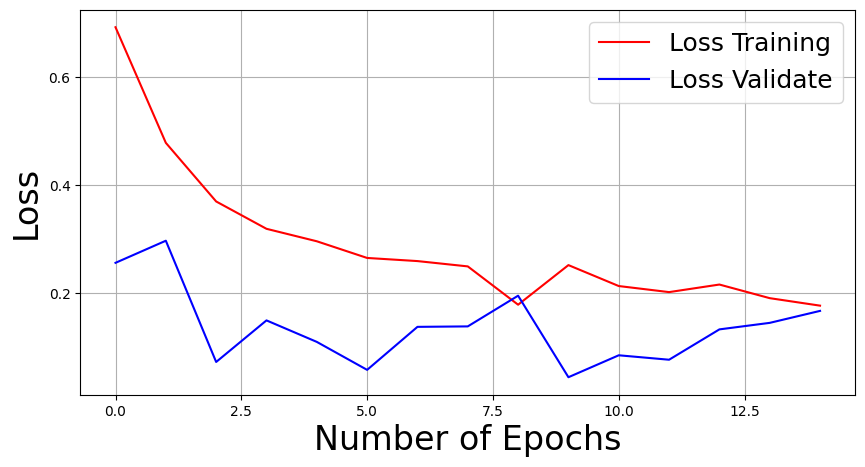

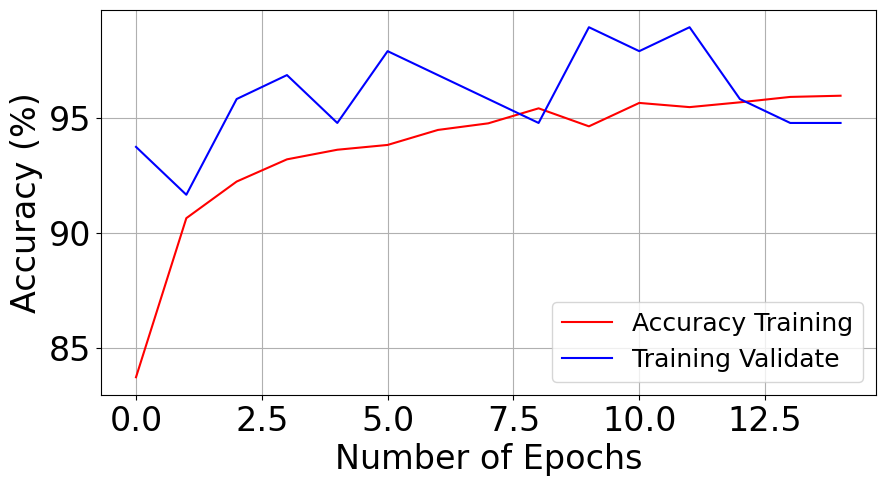

In [11]:
num_epochs_done = len(custom_inceptionv3_model_history.history['loss'])

plotTraining(custom_inceptionv3_model_history, num_epochs_done, "loss")
plotTraining(custom_inceptionv3_model_history, num_epochs_done, "accuracy")
plotTraining(custom_inceptionv3_model_history, num_epochs_done, "val_loss")
plotTraining(custom_inceptionv3_model_history, num_epochs_done, "val_accuracy")

AFRICAN OYSTER CATCHER


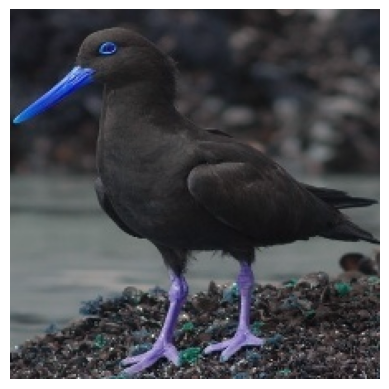

In [12]:
import cv2
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array

names = ['ABBOTTS BABBLER',
          'ABBOTTS BOOBY',
          'ABYSSINIAN GROUND HORNBILL',
          'AFRICAN CROWNED CRANE',
          'AFRICAN EMERALD CUCKOO',
          'AFRICAN FIREFINCH',
          'AFRICAN OYSTER CATCHER',
          'AFRICAN PIED HORNBILL',
          'AFRICAN PYGMY GOOSE',
          'ALBATROSS',
          'ALBERTS TOWHEE',
          'ALEXANDRINE PARAKEET',
          'ALPINE CHOUGH',
          'ALTAMIRA YELLOWTHROAT',
          'AMERICAN AVOCET',
          'AMERICAN BITTERN',
          'AMERICAN COOT',
          'AMERICAN DIPPER',
          'AMERICAN FLAMINGO',
          'AMERICAN GOLDFINCH',
          'AMERICAN KESTREL',
          'AMERICAN PIPIT',
          'AMERICAN REDSTART',
          'AMERICAN ROBIN']

# cargar el modelo
# modelt = load_model("model_VGG16.h5")
modelt = load_model(r"C:\Users\johns\Desktop\TFG\NA\EfficientNetB7\custom_inceptionv3_NAmodel.h5")

# ruta de la imagen
# imaget_path = "/content/drive/MyDrive/TFG/dataset/test/JILGUERO EUROPEO/15.jpg"
imaget_path = r"C:\Users\johns\Desktop\TFG\NA\test\AFRICAN OYSTER CATCHER\2.jpg"

# cargar y redimensionar la imagen
imaget = load_img(imaget_path, target_size=(width_shape, height_shape))
imaget = img_to_array(imaget)
imaget = imaget.reshape((1,) + imaget.shape)

# preprocesar la imagen
xt = imaget / 255.0  # Normalizar la imagen

# hacer predicciones
preds = modelt.predict(xt)

# obtener la clase predicha
predicted_class = np.argmax(preds)
class_name = names[predicted_class]

print(class_name)

# mostrar la imagen
plt.imshow(cv2.cvtColor(imaget.reshape(width_shape, height_shape, 3).astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Found 120 images belonging to 24 classes.


C:\Users\johns\AppData\Local\Temp\ipykernel_3568\786337368.py:29: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = custom_Model.predict_generator(generator=test_generator, steps=len(test_generator))


              precision    recall  f1-score   support

           0     0.8333    1.0000    0.9091         5
           1     1.0000    1.0000    1.0000         5
           2     1.0000    1.0000    1.0000         5
           3     1.0000    1.0000    1.0000         5
           4     1.0000    1.0000    1.0000         5
           5     1.0000    1.0000    1.0000         5
           6     1.0000    1.0000    1.0000         5
           7     1.0000    1.0000    1.0000         5
           8     1.0000    1.0000    1.0000         5
           9     1.0000    1.0000    1.0000         5
          10     1.0000    1.0000    1.0000         5
          11     1.0000    1.0000    1.0000         5
          12     1.0000    1.0000    1.0000         5
          13     1.0000    1.0000    1.0000         5
          14     1.0000    1.0000    1.0000         5
          15     1.0000    1.0000    1.0000         5
          16     1.0000    1.0000    1.0000         5
          17     1.0000    

<Figure size 1500x1500 with 0 Axes>

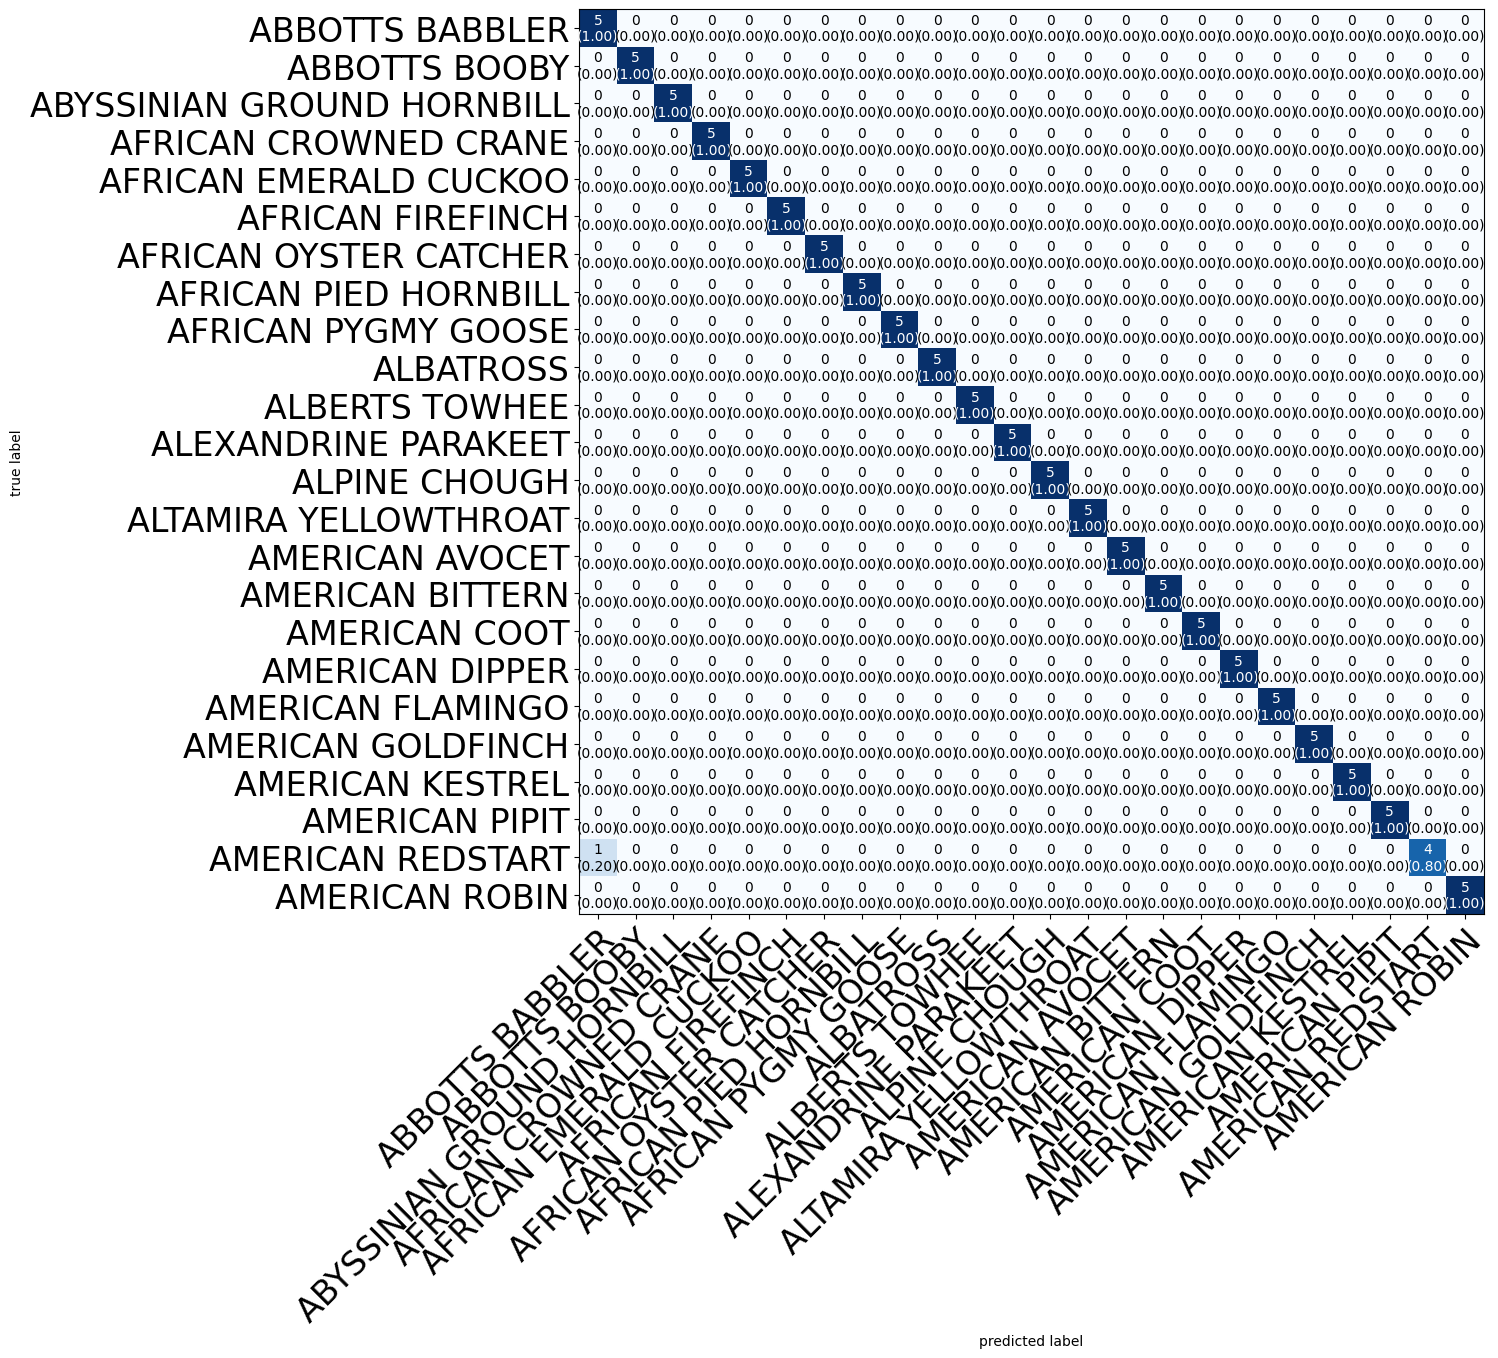

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
%matplotlib inline

# Definir el generador de datos de prueba
test_data_dir = r'C:\Users\johns\Desktop\TFG\NA\test'

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(height_shape, width_shape),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# Load the model
custom_Model= load_model(r"C:\Users\johns\Desktop\TFG\NA\EfficientNetB7\custom_inceptionv3_NAmodel.h5")

# Make predictions
predictions = custom_Model.predict_generator(generator=test_generator, steps=len(test_generator))
y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes

# Map class names to class indices
class_indices = test_generator.class_indices
names = list(class_indices.keys())

# Generate confusion matrix
conf_matrix = confusion_matrix(y_real, y_pred)

# Plot confusion matrix
plt.figure(figsize=(15, 15))

plot_confusion_matrix(conf_mat=conf_matrix, figsize=(15, 15), class_names=names, show_normed=True)
plt.tight_layout()

# Print classification report
print(classification_report(y_real, y_pred, digits = 4))

In [14]:
print(y_real)

[ 0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4
  4  5  5  5  5  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9
  9  9 10 10 10 10 10 11 11 11 11 11 12 12 12 12 12 13 13 13 13 13 14 14
 14 14 14 15 15 15 15 15 16 16 16 16 16 17 17 17 17 17 18 18 18 18 18 19
 19 19 19 19 20 20 20 20 20 21 21 21 21 21 22 22 22 22 22 23 23 23 23 23]


In [15]:
print(y_pred)

[ 0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4
  4  5  5  5  5  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9
  9  9 10 10 10 10 10 11 11 11 11 11 12 12 12 12 12 13 13 13 13 13 14 14
 14 14 14 15 15 15 15 15 16 16 16 16 16 17 17 17 17 17 18 18 18 18 18 19
 19 19 19 19 20 20 20 20 20 21 21 21 21 21 22 22 22  0 22 23 23 23 23 23]
